# Basic Code for RNN (LSTM)

***

### Notes

* Does not support COCOB optimizer.
* Does not have peephole options for cells.
* Recursive approach to forecasts - always produces forecast of horizon 1 and uses as input for next period.
* Using L1 loss.
* Hyperparameters in DARTS package available to tune (intervals are from Hewamalage, Bergmeir, Bandara (2021):
    * Batch size: 40-100
    * Epochs: 3-30
    * Epoch size: 2-10
    * L2 Reg: 0.0001-0.0008
    * Cell dimension: 20-50
    * Number layers: 1-2
    * Standard deviation of initializer: 0.0001-0.0008
    * learning rate (optimizer kwargs): 0.001-0.1
    * training length (length of sampled time series) (come up with bounds)

### Importing Modules and Data

In [44]:
from darts import TimeSeries
import pandas as pd
import numpy as np

from data_processing_functions import *

from darts.models.forecasting.rnn_model import RNNModel
from sktime.performance_metrics.forecasting import mean_absolute_error

from torch import nn

from sktime.utils.plotting import plot_series

In [2]:
# import monthly micro time series
# ignore header and skip the first row to use integers as column names
full_data = pd.read_csv("../../Data/Train/Clean/full_m3_monthly_micro_clean.csv", header=None, skiprows=1)

In [3]:
# convert to a list of series, potentially with different lengths
# drop NA values
full_data = [x.dropna() for _, x in full_data.iterrows()]

In [4]:
# forecast horizon
h = 1

In [5]:
# create train and test set using forecast horizon
Y = [x.iloc[:-h] for x in full_data]
Test = [x.iloc[-h:] for x in full_data]
Test = pd.DataFrame([x.reset_index(drop=True) for x in Test]).T

***

In [6]:
transform_dict = {"deseasonalize": {"sp": 12, "seasonality_type": "additive"}}

In [7]:
processed, _, _, _, _ = pre_process(ts_data=Y,
                                 target_forecast_period=h,
                                 mean_normalize=True,
                                 log=True,
                                 transform_dict=transform_dict)

In [8]:
# convert to type np.float32 to speed up training
processed = [x.astype(np.float32) for x in processed]

In [9]:
# convert dataframe index to a RangeIndex
for i in range(len(processed)):
    processed[i].index = pd.RangeIndex(start=0, stop=processed[i].shape[0]) 

In [10]:
processed = [TimeSeries.from_series(x) for x in processed]

In [11]:
# RNN parameters
input_chunk_length = 24
training_length = 30
model = "LSTM"
MAX_SAMPLES_PER_TS = 5
NUM_EPOCHS = 10

In [12]:
# instantiate the model
RNN = RNNModel(input_chunk_length=input_chunk_length,
               training_length=training_length,
               model=model,
               random_state=1,
               n_epochs=10)

### Model Training

In [13]:
# fit the model
RNN.fit(series=processed, max_samples_per_ts=MAX_SAMPLES_PER_TS)

[2022-07-01 09:07:30,932] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 2370 samples.
[2022-07-01 09:07:30,932] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 2370 samples.
2022-07-01 09:07:30 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 2370 samples.
[2022-07-01 09:07:30,949] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 32-bits; casting model to float32.
[2022-07-01 09:07:30,949] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 32-bits; casting model to float32.
2022-07-01 09:07:30 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 32-bits; casting model to float32.
2022-07-01 09:07:30 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-07-01 09:07:30 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-07-01 09:07:30 pytorc

Training: 0it [00:00, ?it/s]

***

### Creating Subsets of Series with the same length and convertime to `TimeSeries` object.

In [14]:
# # find all series lengths
# ts_lengths = [len(y) for y in Y]

In [15]:
# # find the unique lengths
# unique_lengths = np.unique(ts_lengths)

In [16]:
# length_clusters = [[i for i in np.where(ts_lengths == unique_lengths[j])[0]] for j in range(len(unique_lengths))]

In [17]:
# # pick a cluster for testing
# cluster_num = 0

In [18]:
# # define a cluster of series with the same length
# cluster_1 = [Y[i] for i in length_clusters[cluster_num]]
# # valid_1 = [validation[i] for i in length_clusters[cluster_num]]

### Pre-process the Data

In [19]:
# transform_dict = {"deseasonalize": {"sp": 12, "seasonality_type": "additive"}}

In [20]:
# processed, _, _, _ = pre_process(ts_data=cluster_1,
#                                  target_forecast_period=h,
#                                  mean_normalize=True,
#                                  log=True,
#                                  transform_dict=transform_dict)

In [21]:
# convert to type np.float32 to speed up training
# processed = [x.astype(np.float32) for x in processed]

In [22]:
# # concatenate series into dataframe
# processed_df = pd.concat(processed, axis=1)

In [23]:
# # convert dataframe index to a RangeIndex
# processed_df.index = pd.RangeIndex(start=0, stop=processed_df.shape[0])

In [24]:
# # convert dataframe to TimeSeries object
# ts_data = TimeSeries.from_dataframe(df=processed_df)

***

### Model Setup

In [25]:
# # RNN parameters
# input_chunk_length = 24
# training_length = 36
# model = "LSTM"

In [26]:
# # instantiate the model
# RNN = RNNModel(input_chunk_length=input_chunk_length,
#                training_length=training_length,
#                model=model,
#                random_state=1)

### Model Training

In [27]:
# # fit the model
# RNN.fit(series=ts_data)

### Generate Forecasts

In [46]:
fitted = [RNN.historical_forecasts(series=x, start=24, retrain=False) for x in processed[:18]]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

Predicting: 75it [00:00, ?it/s]

In [47]:
fitted = [x.pd_series().reset_index(drop=True) for x in fitted]

In [52]:
for f in fitted:
    f.index = np.arange(input_chunk_length, len(processed[0]))

In [55]:
fcasts = RNN.predict(n=h, series=processed)

Predicting: 75it [00:00, ?it/s]

In [56]:
fcasts = [x.pd_series().reset_index(drop=True) for x in fcasts]

In [57]:
for f in fcasts:
    f.index = np.arange(len(processed[0]), len(processed[0])+1)

### Post Process Forecasts

In [59]:
fcasts = post_process(full_ts_data=Y,
                      forecasts=fcasts,
                      target_forecast_period=h,
                      mean_normalize=True,
                      log=True,
                      transform_dict=transform_dict)

In [60]:
fitted = post_process(full_ts_data=Y,
                      forecasts=fitted,
                      target_forecast_period=h,
                      mean_normalize=True,
                      log=True,
                      transform_dict=transform_dict)

### Assess Forecast Accuracy

In [61]:
mean_absolute_error(Test, fcasts)

637.6762616641279

In [62]:
fitted

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,3419.229156,1021.645679,3102.954858,1440.948040,4729.174066,1064.943613,2258.968653,2438.377727,3130.187528,4739.152560,3705.312384,3983.243998,3352.017403,4565.281239,1567.887444,871.384194,1822.773619,1862.495403
1,3843.039086,1075.866728,3454.678456,1609.409302,4889.290864,1162.138993,2141.361926,2083.540479,3319.172606,4957.801106,3222.808178,3296.461857,3614.447808,4923.498627,1708.989450,914.327789,1931.047543,1958.967592
2,3977.304845,1216.443402,2932.800816,1561.607302,4630.520324,1208.981102,2334.907369,2109.737604,3011.270913,4825.666925,3400.104496,2973.655714,3523.018862,5043.358738,1729.822698,869.316951,1751.207700,2079.341569
3,3847.299498,1101.764638,3009.700127,1627.740240,4663.973583,1218.189852,2419.655669,2360.113100,2776.444679,4371.542736,3030.902129,2701.114127,3340.492609,4770.837602,1724.139704,952.627245,1751.399875,2135.161254
4,4134.466860,1162.961033,3105.930936,1785.663301,4855.279393,1217.925726,2452.432007,2335.754293,2731.279618,4207.272779,2347.103247,2977.791556,2909.041829,3982.132916,1722.033733,891.841295,1819.753788,2177.420998
5,4155.650021,1321.298912,3093.454283,1869.619942,4825.928668,1352.611314,2610.479148,2339.852467,2690.704668,4057.953589,1759.985749,2597.544566,3085.677716,4163.985750,1888.381622,1049.973239,1818.561110,2152.328982
6,4361.442545,1622.988263,3076.301912,1996.274506,5237.252668,1331.319919,2570.646049,1802.949048,2551.117646,3926.061999,2834.677137,2579.621666,3389.031197,4560.811132,1815.724408,1078.446768,1773.652684,2258.072638
7,3873.638237,1362.646345,3240.841823,2013.585504,5114.623387,1463.389914,2606.232405,1860.258963,2597.332718,3868.102584,3276.311627,2330.071444,2993.656707,4226.503612,1772.794060,1225.445241,1676.082119,2225.593436
8,4160.873495,1472.234448,3339.131625,1982.717179,5139.557263,1565.366432,2593.783716,1897.676217,2549.129420,3749.893998,2805.153909,2669.098821,3217.429650,4530.472248,1837.664611,1187.856877,1703.164664,1904.339599
9,3772.568161,1374.055493,3451.176076,2260.320290,4943.469729,1527.287196,2491.409679,1890.018982,2615.324892,3873.120909,3514.446237,2957.901989,3045.148143,4464.200246,1732.763443,1056.823733,1797.049624,1972.933768


***

In [77]:
temp = fitted.iloc[:,4]

In [78]:
temp.index = np.arange(input_chunk_length, len(processed[0]))

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='4'>)

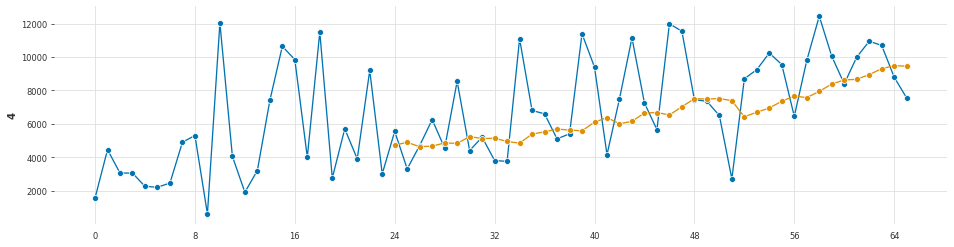

In [79]:
plot_series(Y[4], temp)

***

### Make it loop over all clusters

In [ ]:
# transformation dictionary
transform_dict = {"deseasonalize": {"sp": 12, "seasonality_type": "additive"}}

In [ ]:
# pre-process all data
processed, _, _, _ = pre_process(ts_data=Y,
                                 target_forecast_period=h,
                                 mean_normalize=True,
                                 log=True,
                                 transform_dict=transform_dict)

In [ ]:
# RNN parameters
input_chunk_length = 12
model = "LSTM"

In [ ]:
full_forecasts = np.zeros([len(Y), h, 2])

In [ ]:
for m in range(2):
    for i in length_clusters:
        # define a cluster of series with the same length
        cluster = [Y[j] for j in i]
        cluster_processed = [processed[j] for j in i]
    
        # concatenate series into dataframe
        processed_df = pd.concat(cluster_processed, axis=1)
    
        # convert dataframe index to a RangeIndex
        processed_df.index = pd.RangeIndex(start=0, stop=processed_df.shape[0])
    
        # convert dataframe to TimeSeries object
        ts_data = TimeSeries.from_dataframe(df=processed_df)
    
        # instantiate the model
        RNN = RNNModel(input_chunk_length=input_chunk_length,
                       model=model,
                       loss_fn=nn.L1Loss())
    
        # fit the model
        RNN.fit(series=ts_data)
    
        # generate forecasts
        f = RNN.predict(n=h)
    
        # convert to dataframe
        f = f.pd_dataframe()
    
        # store forecasts in appropriate indexes
        full_forecasts[i,:,m] = f.T

Take the median of the forecasts across the different seed values.

In [ ]:
median_forecasts = np.median(full_forecasts, axis=2)

In [ ]:
median_forecasts = [pd.Series(median_forecasts[i,:]) for i in range(median_forecasts.shape[0])]

In [ ]:
median_forecasts

In [ ]:
fcasts = post_process(full_ts_data=Y,
                      forecasts=median_forecasts,
                      target_forecast_period=h,
                      mean_normalize=True,
                      log=True,
                      transform_dict=transform_dict)

In [ ]:
mean_absolute_error(Test, fcasts)

***

Take a validation set from the end of each sequence and use to optimize hyper-parameters. Then, re-train the networks with the optimal parameters using the full training series, then evaluate on the test data.

In [ ]:
# I think what needs to happen is the algorithm selects a set of parameters which are passed
# to the neural network. This network is fit and evaluated on the validation data, then the a
# algorithm adjusts the parameters. This continuous until optimal parameters are found, then the
# network is trained on the full training data and evaluated on the test data.